# Movie Genre Prediction

This project aims to predict the genre of a movie based on its text summary.

## Data Preparation

Let's start by loading the necessary libraries and preparing the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string
import subprocess
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.stem import LancasterStemmer
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Loading the Dataset

To begin the analysis, the dataset (`genre-classification-dataset-imdb`) is loaded using Pandas, a popular Python library for data manipulation. The `read_csv` function is used to read the CSV file into a Pandas DataFrame.

In [2]:
train = pd.read_csv("/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/train_data.txt", 
                         delimiter=':::' ,header = None ,engine='python')

In [3]:
test = pd.read_csv("/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/test_data.txt",
                         delimiter=':::' ,header = None ,engine='python')

In [4]:
test_data_solution  = pd.read_csv("/kaggle/input/genre-classification-dataset-imdb/Genre Classification Dataset/test_data_solution.txt", 
                                  delimiter=':::' ,header = None ,engine='python')

In [5]:
train

,0,1,2,3
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...
...,...,...,...,...
54209,54210,"""Bonino"" (1953)",comedy,This short-lived NBC live sitcom centered on ...
54210,54211,Dead Girls Don't Cry (????),horror,The NEXT Generation of EXPLOITATION. The sist...
54211,54212,Ronald Goedemondt: Ze bestaan echt (2008),documentary,"Ze bestaan echt, is a stand-up comedy about g..."
54212,54213,Make Your Own Bed (1944),comedy,Walter and Vivian live in the country and hav...


In [6]:
test

,0,1,2
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
4,5,Er nu zhai (1955),Before he was known internationally as a mart...
...,...,...,...
54195,54196,"""Tales of Light & Dark"" (2013)","Covering multiple genres, Tales of Light & Da..."
54196,54197,Der letzte Mohikaner (1965),As Alice and Cora Munro attempt to find their...
54197,54198,Oliver Twink (2007),A movie 169 years in the making. Oliver Twist...
54198,54199,Slipstream (1973),"Popular, but mysterious rock D.J Mike Mallard..."


**Concatenating Test and Train Files**  
In this step, the `train` and `test_data_solution` DataFrames are concatenated into a single DataFrame named `df`. This is performed using Pandas' `concat` function to vertically stack the two DataFrames.

In [7]:
# We will concat the test and train file

df = pd.concat((train ,test_data_solution))
df.columns = ["id" ,"Title","Genre","Description"]
df.head()

,id,Title,Genre,Description
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...


# Data Preprocessing  
**Check for Duplicates and Remove Them**

First, the code checks for duplicates in the dataset using `df.duplicated().sum()`, providing the count of duplicate rows. Then, duplicates are removed from the DataFrame using `df.drop_duplicates(inplace=True)`.

The subsequent code defines a function called `clean_text` that performs various text cleaning operations on the 'Description' column. The operations include converting text to lowercase, removing mentions, URLs, special characters, punctuation, and stop words, as well as filtering out short words.

This function is applied to the 'Description' column, and the cleaned text is stored in a new column called 'Description_clean'. The length of the cleaned text is calculated and stored in a new column called 'Description_clean_length'.

Lastly, the code generates histograms to visualize the distribution of text lengths before and after cleaning. The left plot ('Original Text Length') shows the distribution of original text lengths, while the right plot ('Cleaned Text Length') displays the distribution of cleaned text lengths.

In [8]:
## Check for Duplicates and Remove them
df.duplicated().sum() ## Will give us a number of duplicates

df.drop_duplicates(inplace = True)  ## Will drops any duplicates

In [9]:
# Define the clean_text function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'@\S+', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'pic.\S+', '', text)
    text = re.sub(r"[^a-zA-Z+']", ' ', text)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text + ' ')
    text = "".join([i for i in text if i not in string.punctuation])
    words = nltk.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')
    text = " ".join([i for i in words if i not in stopwords and len(i) > 2])
    text = re.sub("\s[\s]+", " ", text).strip()
    return text
# Apply the clean_text function to the 'Description' column in the training and test data
df["Description_clean"] = df["Description"].apply(clean_text)

In [10]:
df['Description_clean_length']=df['Description_clean'].apply(len)

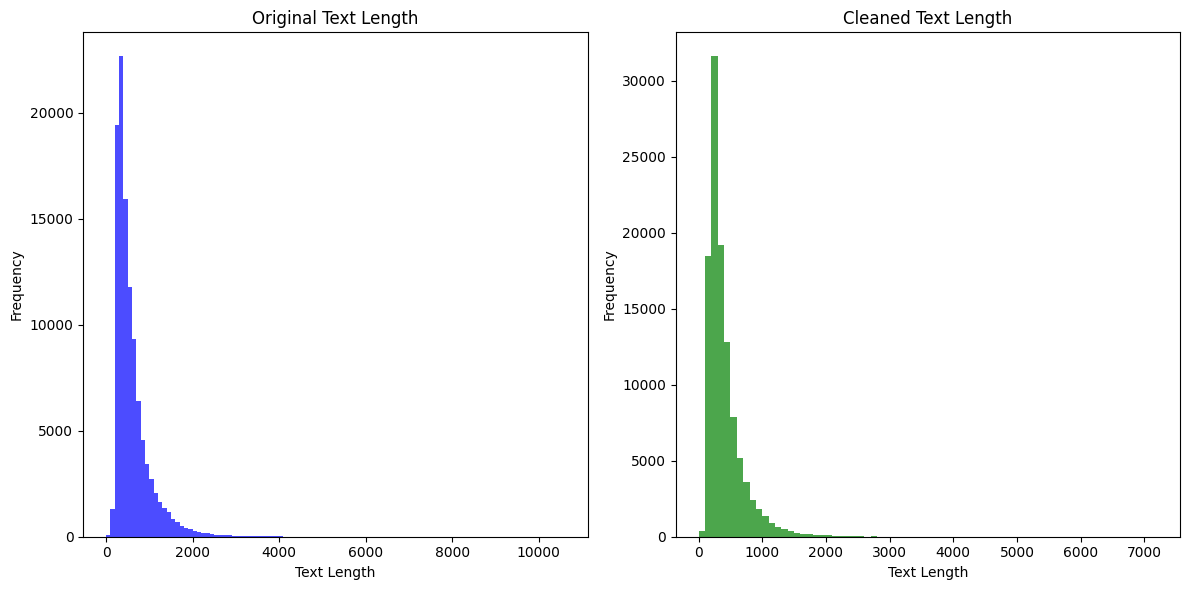

In [11]:
plt.figure(figsize=(12, 6))

# Original text length distribution
plt.subplot(1, 2, 1)
original_lengths = df['Description'].apply(len)
plt.hist(original_lengths, bins=range(0, max(original_lengths) + 100, 100), color='blue', alpha=0.7)
plt.title('Original Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

# Cleaned text length distribution
plt.subplot(1, 2, 2)
cleaned_lengths = df['Description_clean'].apply(len)
plt.hist(cleaned_lengths, bins=range(0, max(cleaned_lengths) + 100, 100), color='green', alpha=0.7)
plt.title('Cleaned Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [12]:
# remove id column from head 
data = df.drop(["Title","id"] , axis = 1) # will drop column 
data.head()

,Genre,Description,Description_clean,Description_clean_length
0,drama,Listening in to a conversation between his do...,listening conversation doctor parents year old...,383
1,thriller,A brother and sister with a past incestuous r...,brother sister past incestuous relationship cu...,119
2,adult,As the bus empties the students for their fie...,bus empties students field trip museum natural...,402
3,drama,To help their unemployed father make ends mee...,help unemployed father make ends meet edith tw...,745
4,drama,The film's title refers not only to the un-re...,films title refers recovered bodies ground zer...,402


# Visualization

Text(0, 0.5, 'Count')

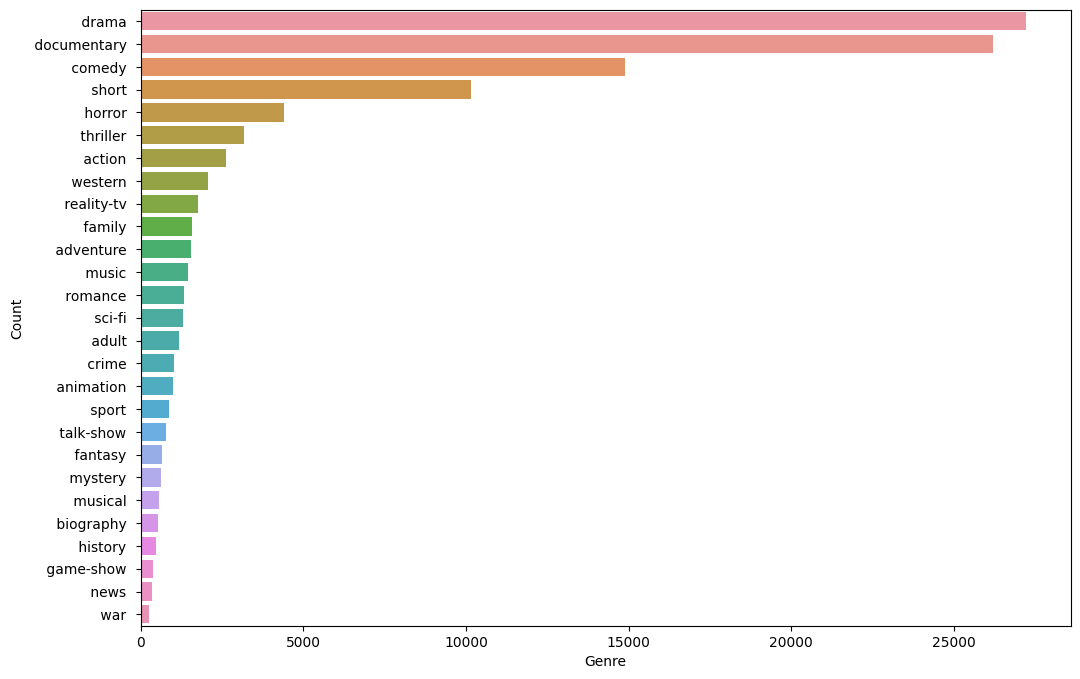

In [13]:
plt.figure(figsize=(12,8))
counts = df.Genre.value_counts()
sns.barplot(x=counts, y=counts.index, orient='h')  
plt.xlabel('Genre')
plt.ylabel('Count')

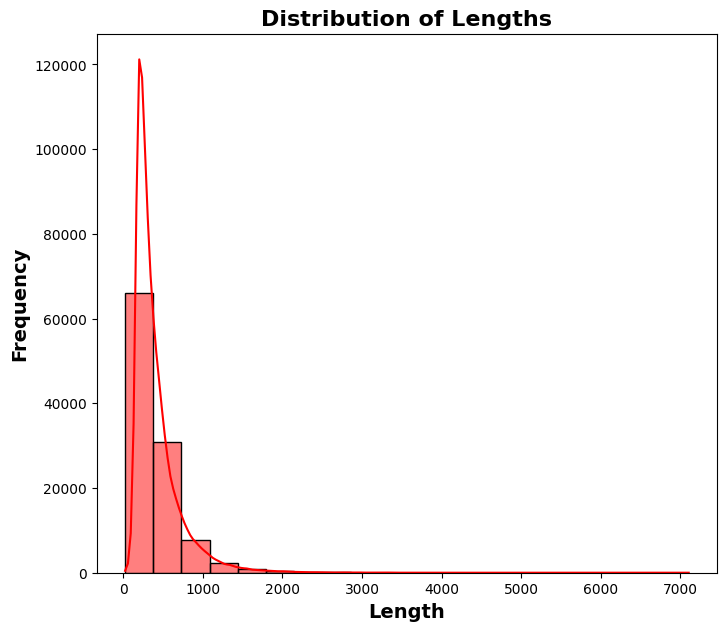

In [14]:
plt.figure(figsize=(8, 7))

sns.histplot(data=df, x='Description_clean_length', bins=20, kde=True, color='red')

plt.xlabel('Length', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.title('Distribution of Lengths', fontsize=16, fontweight='bold')

plt.show()

## Word Lemmatizing and Vectorizing

This section of the code focuses on two key steps: word lemmatization and text vectorization.

### Word Lemmatization

Word lemmatization is a process used to convert words to their base or root form to normalize the text. The code likely uses NLTK's WordNetLemmatizer to perform this task. Lemmatization helps in reducing words to their base form, aiding in better text analysis by consolidating words with the same meaning.

### Text Vectorization

The text vectorization process converts textual data into numerical format, making it suitable for machine learning algorithms. In this case, the code might utilize techniques like TF-IDF (Term Frequency-Inverse Document Frequency) or Word Embeddings (such as Word2Vec or GloVe) to convert the text into numerical vectors.

However, specific details on the exact methods used for lemmatization and vectorization are missing from the code snippet provided. Typically, these processes involve tokenizing the text into words, applying lemmatization to these words, and then transforming them into numerical representations.


In [15]:
nltk.download('wordnet')
# Download and unzip wordnet
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /kaggle/working/...
Archive:  /kaggle/working/corpora/wordnet.zip
   creating: /kaggle/working/corpora/wordnet/
  inflating: /kaggle/working/corpora/wordnet/lexnames  
  inflating: /kaggle/working/corpora/wordnet/data.verb  
  inflating: /kaggle/working/corpora/wordnet/index.adv  
  inflating: /kaggle/working/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/corpora/wordnet/index.verb  
  inflating: /kaggle/working/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/corpora/wordnet/data.adj  
  inflating: /kaggle/working/corpora/wordnet/index.adj  
  inflating: /kaggle/working/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/corpora/wordnet/noun.exc  
  inflating: /kaggle/working/corpora/wordnet/verb.exc  
  inflating: /kaggle/working/corpora/wordne

In [16]:
lemmatizer = nltk.WordNetLemmatizer()
def lemmatizing(text):
    words = nltk.word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

df['lemmatized_Description'] = df['Description_clean'].apply(lambda x: lemmatizing(x))

## Data Preprocessing and Creating Train/Test Sets

This section of the code is dedicated to data preprocessing and the creation of training and testing datasets.

### Checking for Duplicates

The code initially checks for duplicate entries in the dataset using the `duplicated()` function, followed by removing any duplicate rows using the `drop_duplicates()` method.

### Cleaning Text Data

A function named `clean_text()` is defined to preprocess the text data. This function performs various text cleaning operations:
- Converts text to lowercase
- Removes mentions (text starting with '@')
- Removes URLs (text starting with 'http')
- Removes image links (text starting with 'pic.')
- Retains only alphabetical characters and single quotes
- Removes single characters
- Removes punctuation
- Tokenizes the text and removes stopwords
- Strips extra spaces

### Analyzing Text Lengths

The code generates histograms to visualize the distribution of text lengths before and after cleaning. This step helps in understanding how the cleaning process affects the distribution of text lengths in the dataset.

### Word Lemmatizing and Vectorizing

Although the specific details of the lemmatization and vectorization techniques are not explicitly provided, it's likely that the code performs word lemmatization and text vectorization after the text cleaning step. These processes are crucial for transforming text data into a format suitable for machine learning algorithms.


In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['lemmatized_Description'], df["Genre"], test_size=0.2, random_state=42)

# Vectorizing using TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

from gensim.models import Word2Vec

word2vec_model = Word2Vec(sentences=data, vector_size=100, window=5, min_count=1, workers=4)

In [18]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

num_classes = len(label_encoder.classes_)

y_train_onehot = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_onehot = to_categorical(y_test_encoded, num_classes=num_classes)

In [19]:
# Defining LabelEncoder and transforming labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Creating and training the model
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(128, input_shape=(X_train_tfidf.shape[1],), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))  # num_classes, tahmin etmek istediğiniz sınıf sayısıdır


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
import tensorflow as tf
import numpy as np

# Convert your CSR matrices to COO format for easier extraction of indices and values
X_train_tfidf = X_train_tfidf.tocoo()
X_test_tfidf = X_test_tfidf.tocoo()

# Create SparseTensor for training data
X_train_sparse = tf.sparse.SparseTensor(
    indices=np.vstack((X_train_tfidf.row, X_train_tfidf.col)).T,
    values=X_train_tfidf.data,
    dense_shape=X_train_tfidf.shape
)

# Create SparseTensor for testing data
X_test_sparse = tf.sparse.SparseTensor(
    indices=np.vstack((X_test_tfidf.row, X_test_tfidf.col)).T,
    values=X_test_tfidf.data,
    dense_shape=X_test_tfidf.shape
)

# Now you can reorder the SparseTensor
X_train_tfidf_reordered = tf.sparse.reorder(X_train_sparse)
X_test_tfidf_reordered = tf.sparse.reorder(X_test_sparse)

# Train your model again with the reordered data and store the training history
history = model.fit(X_train_tfidf_reordered, y_train_onehot, epochs=10, batch_size=32, validation_data=(X_test_tfidf_reordered, y_test_onehot))

Epoch 1/10
2711/2711 [==============================] - 135s 48ms/step - loss: 1.8254 - accuracy: 0.4871 - val_loss: 1.4626 - val_accuracy: 0.5760
Epoch 2/10
2711/2711 [==============================] - 36s 13ms/step - loss: 1.3260 - accuracy: 0.6206 - val_loss: 1.4219 - val_accuracy: 0.5931
Epoch 3/10
2711/2711 [==============================] - 32s 12ms/step - loss: 1.0409 - accuracy: 0.6992 - val_loss: 1.5022 - val_accuracy: 0.5901
Epoch 4/10
2711/2711 [==============================] - 28s 10ms/step - loss: 0.8307 - accuracy: 0.7564 - val_loss: 1.6449 - val_accuracy: 0.5859
Epoch 5/10
2711/2711 [==============================] - 28s 10ms/step - loss: 0.6788 - accuracy: 0.7989 - val_loss: 1.7962 - val_accuracy: 0.5768
Epoch 6/10
2711/2711 [==============================] - 27s 10ms/step - loss: 0.5558 - accuracy: 0.8327 - val_loss: 2.0331 - val_accuracy: 0.5718
Epoch 7/10
2711/2711 [==============================] - 25s 9ms/step - loss: 0.4735 - accuracy: 0.8556 - val_loss: 2.2416 -

678/678 [==============================] - 2s 3ms/step - loss: 2.7736 - accuracy: 0.5600
Test Accuracy: 0.5599778890609741
678/678 [==============================] - 2s 2ms/step
              precision    recall  f1-score   support

           0       0.40      0.37      0.39       526
           1       0.51      0.39      0.44       228
           2       0.34      0.25      0.29       304
           3       0.24      0.17      0.20       211
           4       0.00      0.00      0.00       103
           5       0.56      0.55      0.56      2988
           6       0.14      0.10      0.12       223
           7       0.69      0.78      0.73      5185
           8       0.59      0.65      0.62      5550
           9       0.20      0.18      0.19       288
          10       0.09      0.07      0.08       147
          11       0.72      0.52      0.60        73
          12       0.00      0.00      0.00       116
          13       0.66      0.62      0.64       883
          1

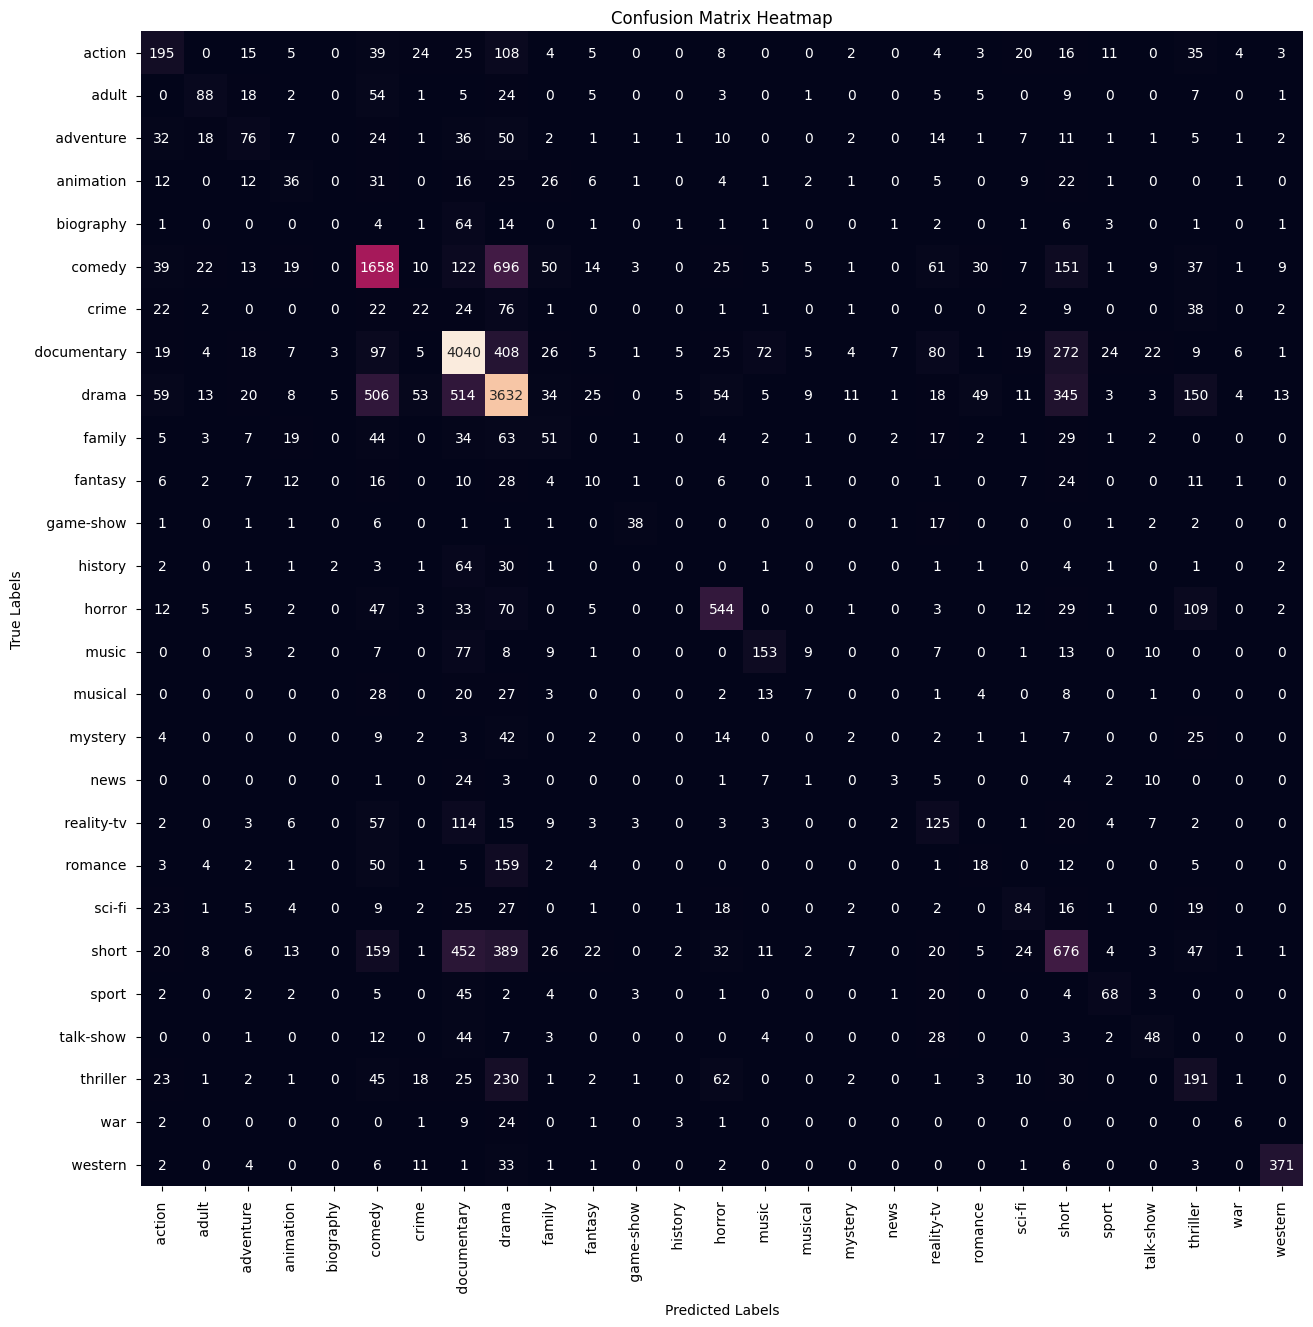

In [21]:
# Evaluate model performance
loss, accuracy = model.evaluate(X_test_tfidf_reordered, y_test_onehot)
print(f"Test Accuracy: {accuracy}")

# Make predictions
y_pred = model.predict(X_test_tfidf_reordered)

# Ensure y_pred is in categorical format (convert probabilities to class labels)
y_pred_classes = np.argmax(y_pred, axis=1)

# Print classification report
print(classification_report(y_test_encoded, y_pred_classes))

# Generate confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred_classes)
class_names = list(label_encoder.classes_)

# Plot confusion matrix
plt.figure(figsize=(15, 15))
sns.heatmap(cm, annot=True, fmt='d', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

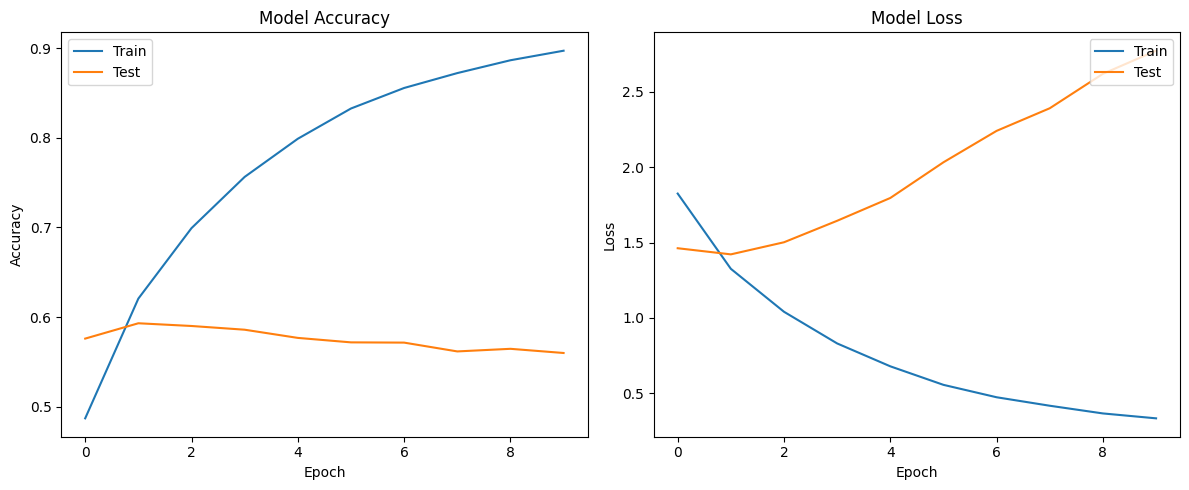

In [22]:
# Plotting loss and accuracy graphs
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')

plt.tight_layout()
plt.show()
